This is my attempt at heurisitic threshold setting to analyse this particular dataset. Here we have a dataset of Global active power, Global reactive power, Voltage, Global intensity, sub_metrix_1 (which represents the power usage in the kitchen); sub_metric_2 (which represents the power useage in the laundry); sub_metric_3 (which represents the power usage by a few heavy appliances, like water heater and air conditioner.) This dataset DOES NOT contain meta data of individual appliance. This poses as a huge downside for this data set. Regardless, i have modelled the classification problem differently. Here, I have defined a new column, which is called total_power, which is the (kitchen + laundry + heavy appliances) power. 

We take the fourier transformation of the reference signal (our appliance) and compare it to sliding windows of the frequency components of multiple parameters. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance

In [3]:

df = pd.read_csv(r'C:\Users\shivk\cml1NILM\household_power_consumption.txt', delimiter=';', parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 na_values=['nan','?'])
df.fillna(0, inplace=True)
df.rename(columns={'Sub_metering_1': 'Kitchen', 'Sub_metering_2': 'Laundry', 'Sub_metering_3': 'Heavy_Appliances'}, inplace=True)

#please import path location according to system requrements. 

C:\Users\shivk\AppData\Local\Temp\ipykernel_21664\3524565247.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(r'C:\Users\shivk\cml1NILM\household_power_consumption.txt', delimiter=';', parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
C:\Users\shivk\AppData\Local\Temp\ipykernel_21664\3524565247.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(r'C:\Users\shivk\cml1NILM\household_power_consumption.txt', delimiter=';', parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,


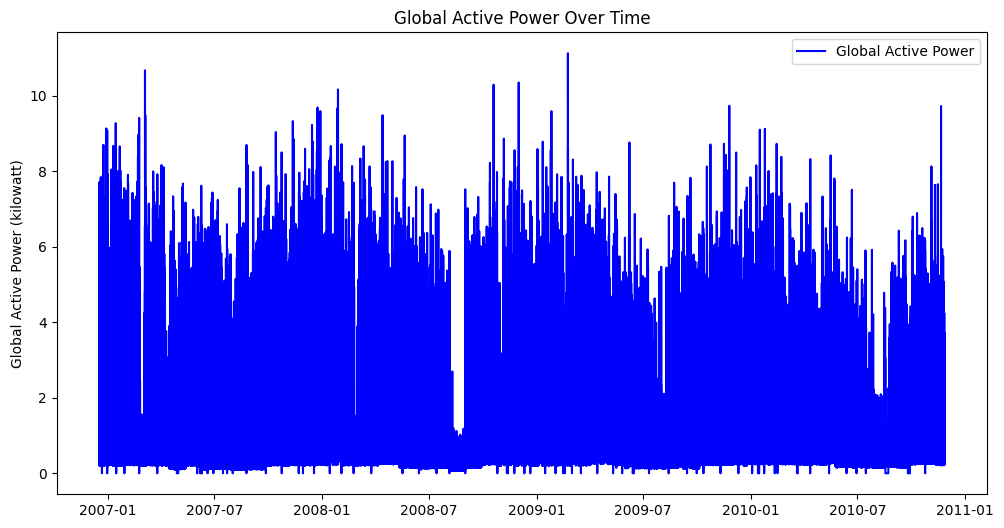

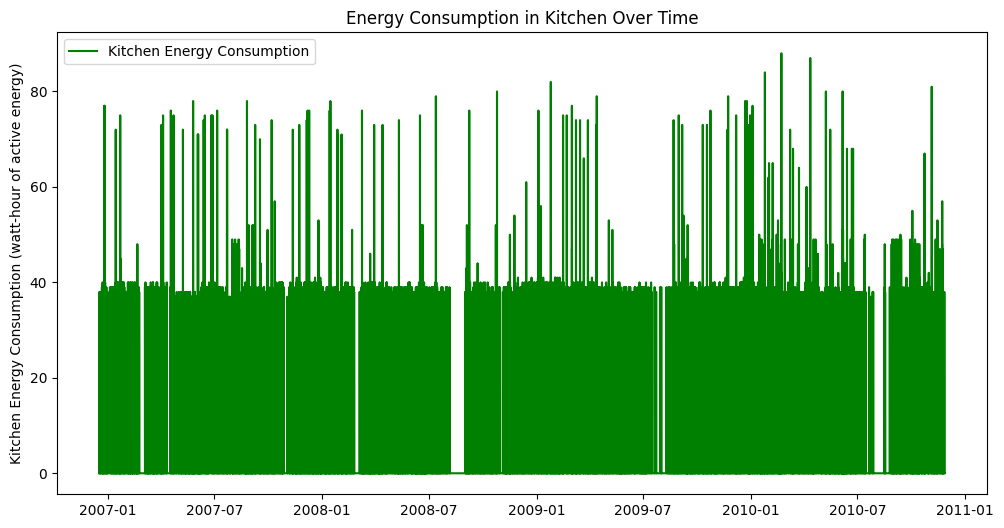

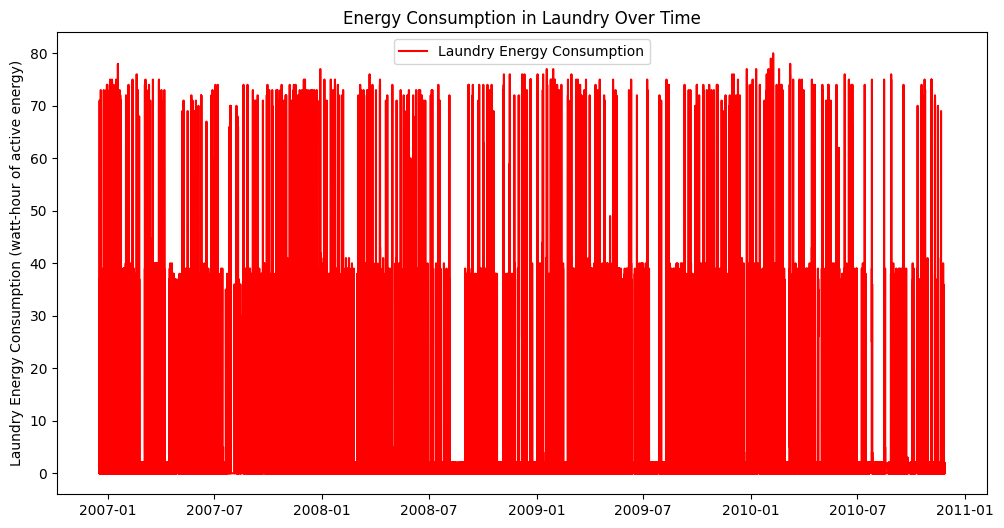

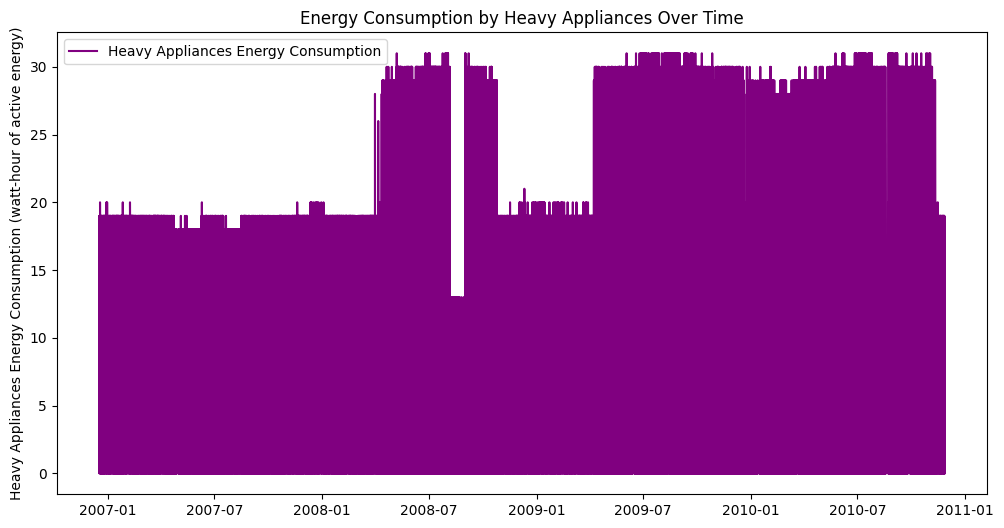

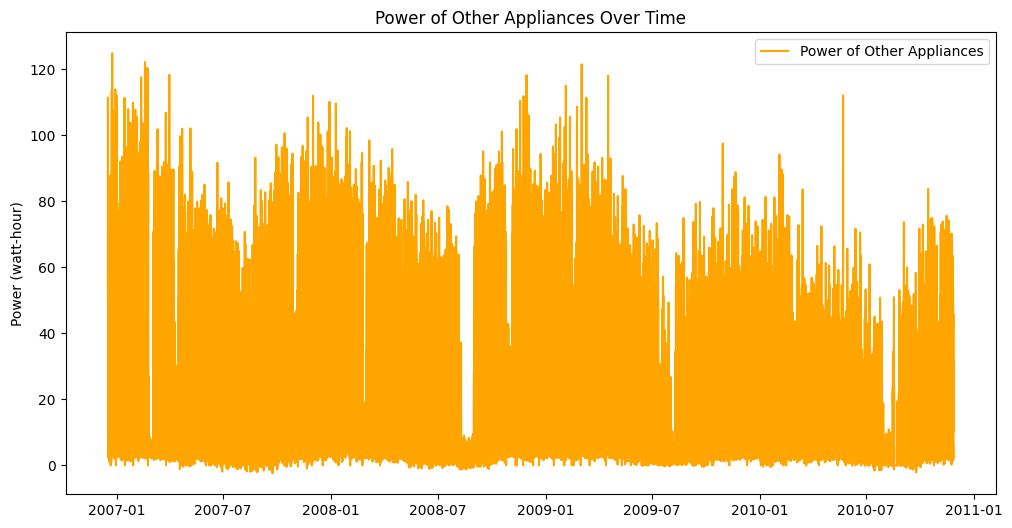

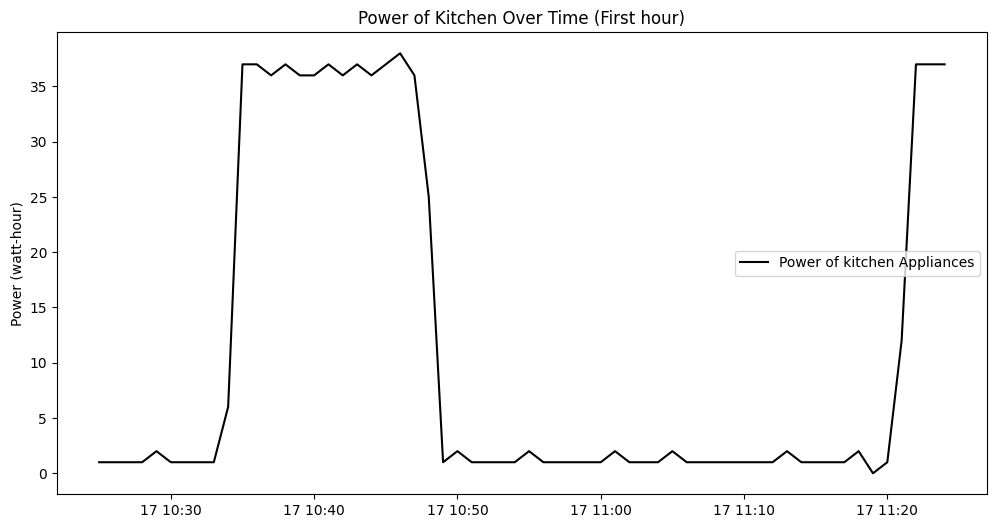

In [50]:

# Plot Global Active Power
plt.figure(figsize=(12,6))
plt.plot(df['dt'], df['Global_active_power'], color='blue', label='Global Active Power')
plt.title('Global Active Power Over Time')
plt.ylabel('Global Active Power (kilowatt)')
plt.legend()
plt.show()

# Plot Energy Consumption in Kitchen
plt.figure(figsize=(12,6))
plt.plot(df['dt'], df['Kitchen'], color='green', label='Kitchen Energy Consumption')
plt.title('Energy Consumption in Kitchen Over Time')
plt.ylabel('Kitchen Energy Consumption (watt-hour of active energy)')
plt.legend()
plt.show()

# Plot Energy Consumption in Laundry
plt.figure(figsize=(12,6))
plt.plot(df['dt'], df['Laundry'], color='red', label='Laundry Energy Consumption')
plt.title('Energy Consumption in Laundry Over Time')
plt.ylabel('Laundry Energy Consumption (watt-hour of active energy)')
plt.legend()
plt.show()

# Plot Energy Consumption by Heavy Appliances
plt.figure(figsize=(12,6))
plt.plot(df['dt'], df['Heavy_Appliances'], color='purple', label='Heavy Appliances Energy Consumption')
plt.title('Energy Consumption by Heavy Appliances Over Time')
plt.ylabel('Heavy Appliances Energy Consumption (watt-hour of active energy)')
plt.legend()
plt.show()

# Compute and Plot the Power for Other Appliances
df['other_power'] = (df['Global_active_power']*1000/60 - df['Kitchen'] - df['Laundry'] - df['Heavy_Appliances'])
plt.figure(figsize=(12,6))
plt.plot(df['dt'], df['other_power'], color='orange', label='Power of Other Appliances')
plt.title('Power of Other Appliances Over Time')
plt.ylabel('Power (watt-hour)')
plt.legend()
plt.show()

# Compute and Plot the Power for Kitchen in certain range
plt.figure(figsize=(12,6))
plt.plot(df['dt'][1021:1081], df['Kitchen'][1021:1081], color='k', label='Power of kitchen in certain range')
plt.title('Power of Kitchen Over Time (First hour)')
plt.ylabel('Power (watt-hour)')
plt.legend()
plt.show()


This is a part of our kitchen signal. We are assuming this is our "REFERENCE APPLIANCE"

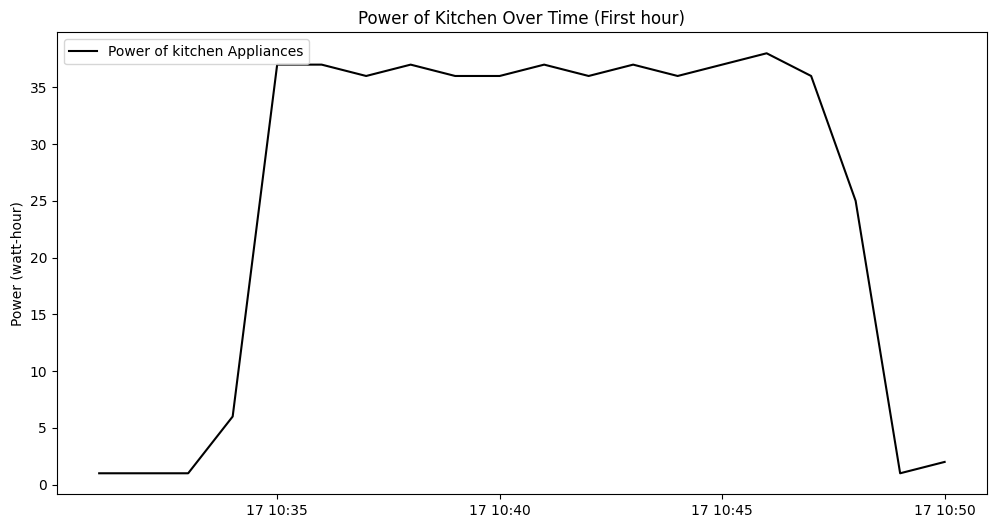

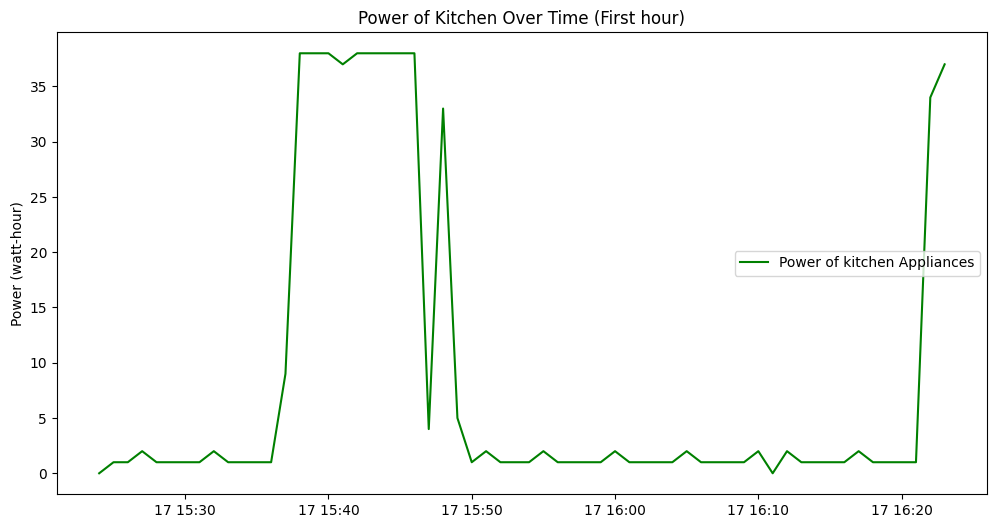

In [54]:
plt.figure(figsize=(12,6))
plt.plot(df['dt'][1027:1047], df['Kitchen'][1027:1047], color='k', label='Power of kitchen Appliances')

plt.title('Power of Kitchen Over Time (First hour)')
plt.ylabel('Power (watt-hour)')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(df['dt'][1320:1380], df['Kitchen'][1320:1380], color='green', label='Power of kitchen Appliances')
plt.title('Power of Kitchen Over Time (First hour)')
plt.ylabel('Power (watt-hour)')
plt.legend()
plt.show()

In [4]:
df['total_power'] = df['Kitchen'] + df['Laundry'] + df['Heavy_Appliances']

Next, we are taking the Fast fourier transform of a fixed window of total power and kitchen to analyze the data. 

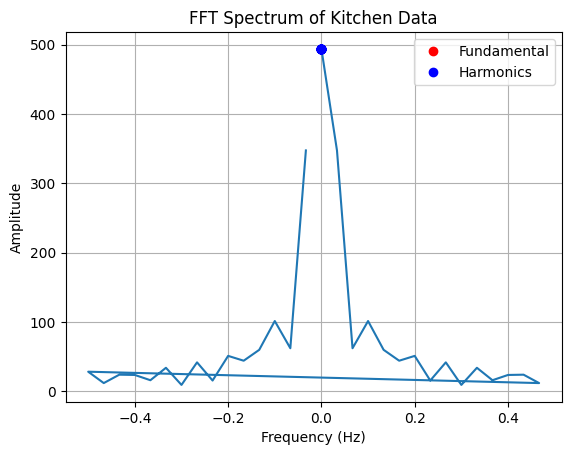

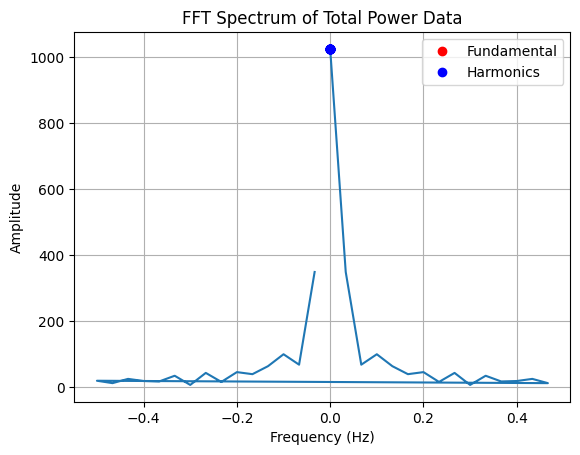

In [77]:

kitchen_data = df['Kitchen'][1020:1050]
total_power_data = df['total_power'][1020:1050]
kitchen_fft = np.fft.fft(kitchen_data)
kitchen_spectrum = np.abs(kitchen_fft)

# Generate the frequency axis for the spectrum

sampling_rate = 1  # Assuming the data is sampled at 1 Hz
frequency_axis_kitchen = np.fft.fftfreq(len(kitchen_data), d=1/sampling_rate)

# Perform FFT on the total_power_data
total_power_fft = np.fft.fft(total_power_data)
# Compute the magnitude spectrum (absolute values of complex amplitudes)
total_power_spectrum = np.abs(total_power_fft)
# Generate the frequency axis for the spectrum
frequency_axis_total_power = np.fft.fftfreq(len(total_power_data), d=1/sampling_rate)

# Plotting the FFT spectrum of 'Kitchen' data
plt.figure()
plt.plot(frequency_axis_kitchen, kitchen_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT Spectrum of Kitchen Data')
plt.grid(True)

# Find the index corresponding to the fundamental frequency in 'Kitchen' data
fundamental_index_kitchen = np.argmax(kitchen_spectrum)

# Find the indices corresponding to the harmonics in 'Kitchen' data
harmonics_indices_kitchen = []
for i in range(2, len(kitchen_spectrum)):
    harmonic_index = fundamental_index_kitchen * i
    if harmonic_index < len(kitchen_spectrum):
        harmonics_indices_kitchen.append(harmonic_index)

plt.plot(frequency_axis_kitchen[fundamental_index_kitchen], kitchen_spectrum[fundamental_index_kitchen], 'ro', label='Fundamental')
plt.plot(frequency_axis_kitchen[harmonics_indices_kitchen], kitchen_spectrum[harmonics_indices_kitchen], 'bo', label='Harmonics')

plt.legend()

# Plotting the FFT spectrum of 'total_power' data
plt.figure()
plt.plot(frequency_axis_total_power, total_power_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT Spectrum of Total Power Data')
plt.grid(True)

# Find the index corresponding to the fundamental frequency in 'total_power' data
fundamental_index_total_power = np.argmax(total_power_spectrum)

# Find the indices corresponding to the harmonics in 'total_power' data
harmonics_indices_total_power = []
for i in range(2, len(total_power_spectrum)):
    harmonic_index = fundamental_index_total_power * i
    if harmonic_index < len(total_power_spectrum):
        harmonics_indices_total_power.append(harmonic_index)

# Add markers for the fundamental frequency and its harmonics in 'total_power' data
plt.plot(frequency_axis_total_power[fundamental_index_total_power], total_power_spectrum[fundamental_index_total_power], 'ro', label='Fundamental')
plt.plot(frequency_axis_total_power[harmonics_indices_total_power], total_power_spectrum[harmonics_indices_total_power], 'bo', label='Harmonics')

plt.legend()

plt.show()


first let us check the plot of the reference waveform. WE HAVE ASSUMED THIS TO BE THE KITCHEN WAVE BETWEEN TIME STAMP 1021 and 1081

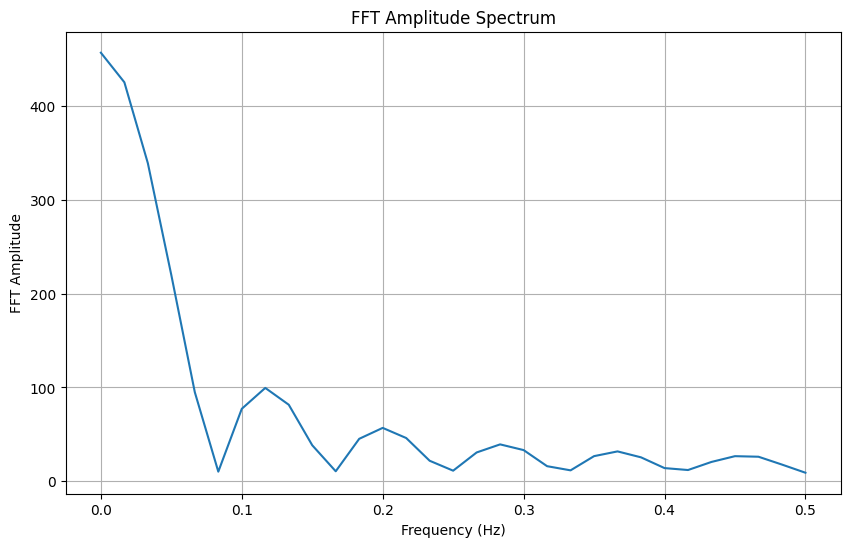

In [72]:
import matplotlib.pyplot as plt

def plot_fft_amplitude(df, ref_index, window_size):
    # Define the reference window from the 'Kitchen' column and compute its FFT
    ref_window = df['Kitchen'][ref_index : ref_index + window_size].values
    ref_fft = np.fft.rfft(ref_window)

    # Get the amplitude spectrum and the corresponding frequencies
    ref_amp = np.abs(ref_fft)
    freq = np.fft.rfftfreq(window_size, d=1)  # Here, d=1 assumes your data is sampled at 1 Hz
    
    # Plot the FFT amplitude spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(freq, ref_amp)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('FFT Amplitude')
    plt.title('FFT Amplitude Spectrum')
    plt.grid(True)
    plt.show()

# Call the function
df_reset = df.reset_index(drop=True)
ref_index = 1021
window_size = 60
plot_fft_amplitude(df_reset, ref_index, window_size)


Now, when we traverse through the signal in time domain (using a sliding window of pane_size = 60); we slide it, while increasing start index by 5minutes everytime. Essentially sliding the pane first between 0-60, then 5-65 etc. This 5 is called the increment that can be a changable value. 

In [ ]:

def check_amplitude_and_frequency(df,window_size, pane_size, increment, ref_index, min_total_power_dist, min_kitchen_dist):
    # Define the reference window from the 'Kitchen' column and compute its FFT
    ref_window = df['Kitchen'][ref_index : ref_index + window_size].values
    ref_fft = np.fft.rfft(ref_window)
    ref_amp = np.abs(ref_fft)
    
    # Initialize counter for each category
    counter = np.zeros(4)
    n_windows = 0

    for start_index in range(0, len(df) - pane_size, increment):
        end_index = start_index + pane_size

        # Calculate the FFT for the total power and kitchen for each window
        total_power_window = df['total_power'][start_index : end_index].values
        kitchen_window = df['Kitchen'][start_index : end_index].values
        
        total_power_fft = np.fft.rfft(total_power_window)
        kitchen_fft = np.fft.rfft(kitchen_window)

        # Get the amplitude spectrum
        total_power_amp = np.abs(total_power_fft)
        kitchen_amp = np.abs(kitchen_fft)

        # Compute Euclidean distances between the reference amplitude spectrum and the current windows' amplitude spectra
        dist_total_power = distance.euclidean(ref_amp, total_power_amp)
        dist_kitchen = distance.euclidean(ref_amp, kitchen_amp)

        # Plot the amplitude spectrum for each window
        plt.figure(figsize=(10, 6))
        plt.plot(total_power_amp, label='Total Power')
        plt.plot(kitchen_amp, label='Kitchen')
        plt.xlabel('Frequency bin')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

        # Classify the window based on the conditions and increment the counter
        if dist_total_power < min_total_power_dist and dist_kitchen < min_kitchen_dist:
            counter[3] += 1
        elif dist_total_power < min_total_power_dist:
            counter[1] += 1
        elif dist_kitchen < min_kitchen_dist:
            counter[2] += 1
        else:
            counter[0] += 1
        
        n_windows += 1
            
    # Calculate accuracy
    accuracy = (counter[0] + counter[3]) / n_windows

    return counter, accuracy
min_total_power_distance = 20
min_kitchen_distance = 10
pane_size = 60
increment = 5
window_size = 60 #for now lets assume window size and pane size is the same. Otherwise likely that window_size (size of reference) is less than pane size
# Call the function
df_reset = df.reset_index(drop=True)
ref_index = 1021 #the reference is between 1021 and 1081 
counter, accuracy = check_amplitude_and_frequency(df_reset, window_size, pane_size, increment, ref_index, min_total_power_distance, min_kitchen_distance)

print("Counter: ", counter)
print("Accuracy: ", accuracy) 

In the analysis, one of the primary objectives is to identify when the spectral power (frequency count) of the 'total_power' signal can be expressed as a linear combination of the spectra of different appliance signals (kitchen, laundry, heavy appliances, etc.). This is represented by the equation ax1 + bx2 + cx3, where x1, x2, and x3 correspond to the frequency counts of kitchen, laundry and heavy appliances, respecitvely . A minor condition applied is that the spectral power of 'total_power' should exceed that of 'kitchen' at least 75% of the time.

We take a sliding window of increment 5 minutes, where analysis takes place comparing the reference to 0-60, 5-65 etc. The increment here is 5, and can be changed. Let us take a particular sliding window.
The analysis also includes some conditions for data classification based on the presence or absence of a 'reference frequency' in the 'total_power' and 'kitchen' signals. This is done by calculating how closely the spectra of the total_power and kitchen signals resemble the spectral of the reference window. This resembelence is measured as a Euclidean distance between the spectra, with lower values indication a closer resembelence. If both kitchen and total_power have distance more than this threshold, they are assigned a value 0. If both have distance less than threshold, the sliding window is assigned a 3. If total power distance exceeds the threshold and kitchen doesnt, it essentially means that this reference is present in total power, but it doesnt correspond to kitchen, It rather corresponds to some other frequency components (perhaps from laundry or heavy appliances) this gets assigned a value 1 (these are collission errors). If total doesnt match but kitchen matches, it is assigned a 2 (this is the primary spot for errors which doesnt come from collisions )

The accuracy depends on the values assigned a 0 and a 3. We ensure that total_power exceeds the kitchen, and the rest are discarded (this policy should be true astleast 75% of the time which is represented as a variable called mean. )
 If a window of data assigned 0 or 3 doesn't meet these conditions, it is 'discarded' and pushed into a separate dataframe for further analysis. This strategy is an effective way to reuse the data that initially failed to meet the criteria.

In the follow-up analysis of the discarded data, the conditions are relaxed by increasing the thresholds min_total_power_dist and min_kitchen_dist by 25. This essentially doesnt do much, since already discarded data fullfill the initial threshold. This just tightens conditions to return/exit our recursive loop. 

However, this is counterbalanced by relaxation of another condition: the requirement for 'total_power' to exceed 'kitchen' is now enforced at least 60% of the time, compared to the initial 75%. To prevent infinite recursion and progressively worse data, the code ensures that this threshold never falls below 40%.

Throughout the entire process, all the classification outcomes are stored in a results dictionary. This includes outcomes from multiple recursions, which helps in tracking how the classification results evolve as the conditions are modified across iterations.

In [45]:
import numpy as np
from scipy.spatial import distance

def check_amplitude_and_frequency_new2(df, window_size, pane_size, increment, ref_index, min_total_power_dist, min_kitchen_dist, mean):
    # Stop condition
    if mean <= 0.4 and min_total_power_dist > 100 and min_kitchen_dist > 100:
        return {}

    # Define the reference window from the 'Kitchen' column and compute its FFT
    ref_window = df['Kitchen'][ref_index : ref_index + window_size].values
    ref_fft = np.fft.rfft(ref_window)
    ref_amp = np.abs(ref_fft)

    # Initialize a dictionary to store the counter and accuracy for each pair of threshold values
    results = {}
    discard_indices = []

    # Initialize counter for each category and total number of windows
    counter = np.zeros(5) 
    n_windows = 0
    n_discards = 0

    for start_index in range(0, len(df) - pane_size, increment):
        end_index = start_index + pane_size

        # Calculate the FFT for the total power and kitchen for each window
        total_power_window = df['total_power'][start_index : end_index].values
        kitchen_window = df['Kitchen'][start_index : end_index].values
        
        total_power_fft = np.fft.rfft(total_power_window)
        kitchen_fft = np.fft.rfft(kitchen_window)

        # Get the amplitude spectrum
        total_power_amp = np.abs(total_power_fft)
        kitchen_amp = np.abs(kitchen_fft)

        # Calculate the distance to the reference amplitude
        dist_total_power = distance.euclidean(ref_amp, total_power_amp)
        dist_kitchen = distance.euclidean(ref_amp, kitchen_amp)

        if dist_total_power < min_total_power_dist and dist_kitchen < min_kitchen_dist:
            if np.mean(total_power_amp >= ref_amp) >= mean:
                counter[3] += 1
            else:
                counter[4] += 1
                n_discards +=1
                discard_indices.append(start_index)  # Store the start index of discarded window
        elif dist_total_power < min_total_power_dist:
            counter[1] += 1
        elif dist_kitchen < min_kitchen_dist:
            counter[2] += 1
        else:
            if np.mean(total_power_amp >= ref_amp) >= mean:
                counter[0] += 1
            else:
                counter[4] += 1
                n_discards +=1
                discard_indices.append(start_index)  # Store the start index of discarded window
        
        n_windows += 1
    
    # Calculate accuracy
    accuracy = (counter[0] + counter[3]) / (n_windows)

    # Store the counter, accuracy, and total number of windows in the results dictionary
    results[(min_total_power_dist, min_kitchen_dist)] = (counter, accuracy, n_windows-n_discards)

    # Analyze discarded points
    if discard_indices:  # Check if there are discarded windows
        discard_df = df.iloc[discard_indices, :] 

        # Recursively call the function with increased thresholds and halved mean
        discard_results = check_amplitude_and_frequency_new2(discard_df, window_size, pane_size, increment, ref_index, min_total_power_dist + 25, min_kitchen_dist + 25, mean*0.8)
        
        # Merge the result dictionaries
        results.update(discard_results)

    return results


In [47]:
# Call the function
min_total_power_distance = 50
min_kitchen_distance = 50 #both in frequency domain
pane_size = 60
increment = 15
window_size = 60 

# Call the function
df_reset = df.reset_index(drop=True)
ref_index = 1021 
results = check_amplitude_and_frequency_new2(df_reset, window_size, pane_size, increment, ref_index, min_total_power_distance, min_kitchen_distance, 0.75)

# Compute the final accuracy
final_count_0 = sum([res[0][0] for res in results.values()])
final_count_3 = sum([res[0][3] for res in results.values()])
total_windows = sum([res[2] for res in results.values()])
final_accuracy = (final_count_0 + final_count_3) / total_windows

for thresholds, (counter, accuracy, n_windows) in results.items():
    print(f"For min_total_power_dist = {thresholds[0]} and min_kitchen_dist = {thresholds[1]}:")
    print("Counter: ", counter)
    print("Accuracy: ", accuracy)
    print("Number of windows: ", n_windows)
    print()
print(f"Final Accuracy: {final_accuracy}")

For min_total_power_dist = 50 and min_kitchen_dist = 50:
Counter:  [3.83300e+03 2.00000e+00 4.48000e+02 1.00000e+00 1.34059e+05]
Accuracy:  0.027713726028783532
Number of windows:  4284

For min_total_power_dist = 75 and min_kitchen_dist = 75:
Counter:  [3857.    0. 1621.    0. 3456.]
Accuracy:  0.4317215133199015
Number of windows:  5478

For min_total_power_dist = 100 and min_kitchen_dist = 100:
Counter:  [ 26.   0. 200.   1.   0.]
Accuracy:  0.11894273127753303
Number of windows:  227

Final Accuracy: 0.772649914906397


We can see here that index 0 and 3 of the counter matrix correspond to when our algorithm is accurate. Index 1 is positions of collissions (or where some other room has similar frequency response as the referenced appliance so it acts as a collission error) Index 3 is the position where there is a real error, and is seeingly minimum. 

The next code is just to look at both kitchen and total_power. This just makes us look at the big picture. Remember, our goal is to NOT compare the two directly. We are just checking if our appliance, called reference, is present in both. then we can say that reference is hogging up power. due to the lack of meta data, reference is just a small part of kitchen data here. It can be any signal practically. 

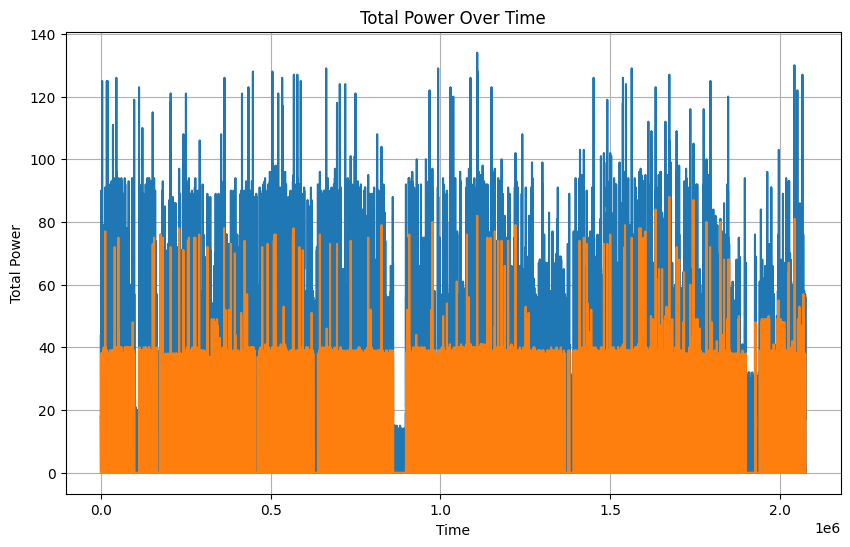

In [49]:
import matplotlib.pyplot as plt

# Plot total_power
plt.figure(figsize=(10,6))
plt.plot(df_reset['total_power'])
plt.plot(df_reset['Kitchen'])
plt.title('Total Power Over Time')
plt.xlabel('Time')
plt.ylabel('Total Power')
plt.grid(True)
plt.show()



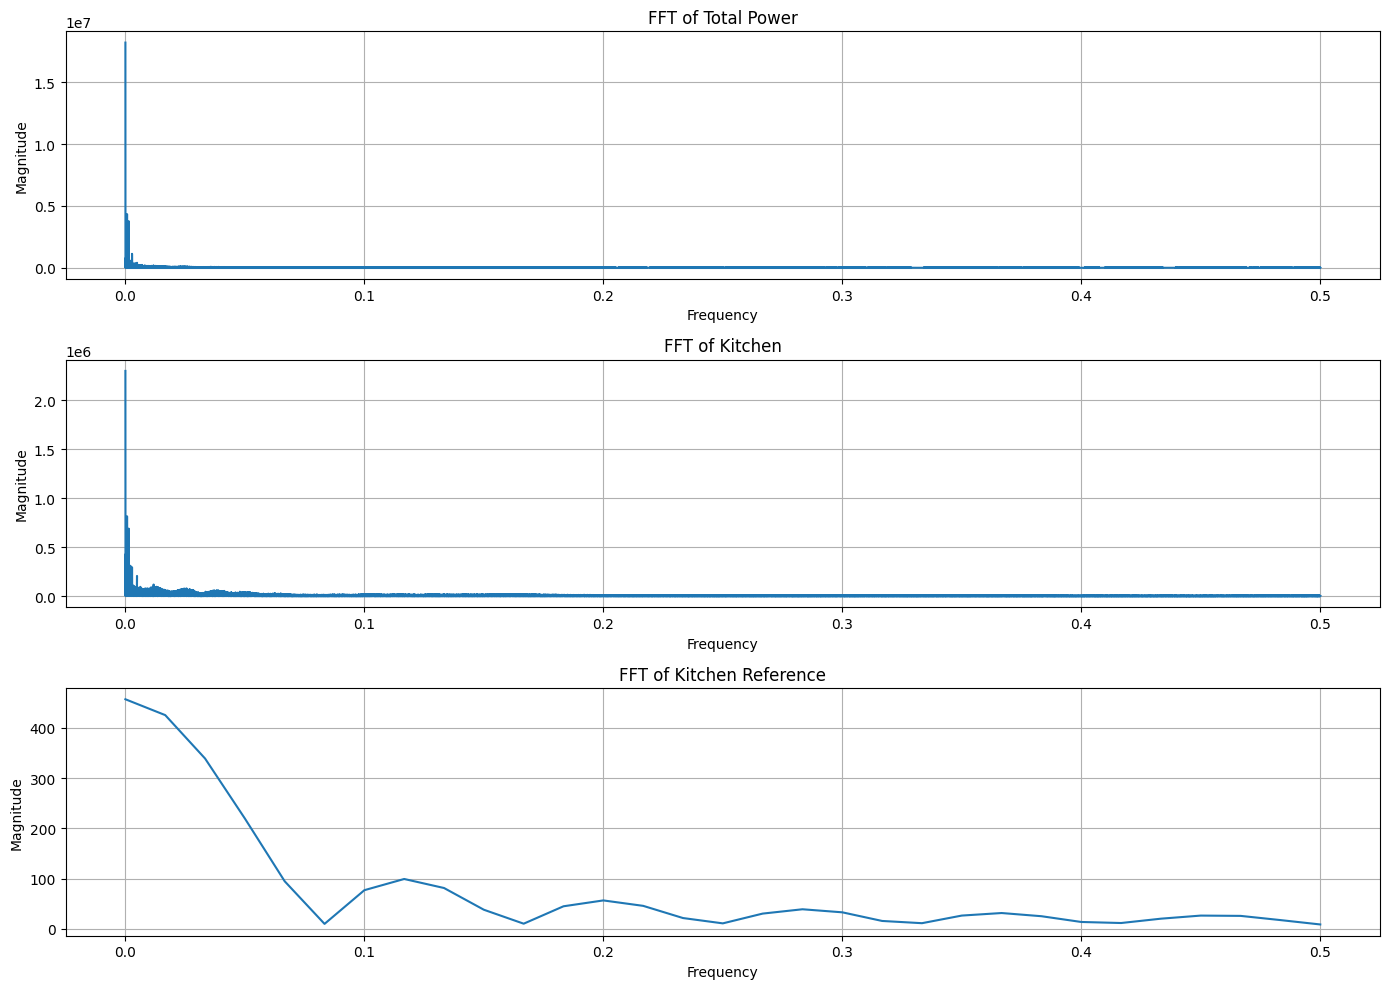

In [51]:
# Extract the reference kitchen window
kitchen_ref = df_reset['Kitchen'][1021:1081]

# Compute its FFT
kitchen_ref_fft = np.fft.rfft(kitchen_ref)

# Compute the associated frequencies for the reference window
freq_ref = np.fft.rfftfreq(kitchen_ref.size, d=1)

# Plot the magnitudes of the FFTs
plt.figure(figsize=(14,10))

# total_power
plt.subplot(3, 1, 1)
plt.plot(freq, np.abs(total_power_fft))
plt.title('FFT of Total Power')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True)

# Kitchen
plt.subplot(3, 1, 2)
plt.plot(freq, np.abs(kitchen_fft))
plt.title('FFT of Kitchen')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True)

# Kitchen Reference
plt.subplot(3, 1, 3)
plt.plot(freq_ref, np.abs(kitchen_ref_fft))
plt.title('FFT of Kitchen Reference')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


The next code is an example when the reference appliance is in both kitchen and total power. Our reference is being used in the kitchen. 

Classification for window starting at index 1119857: 3


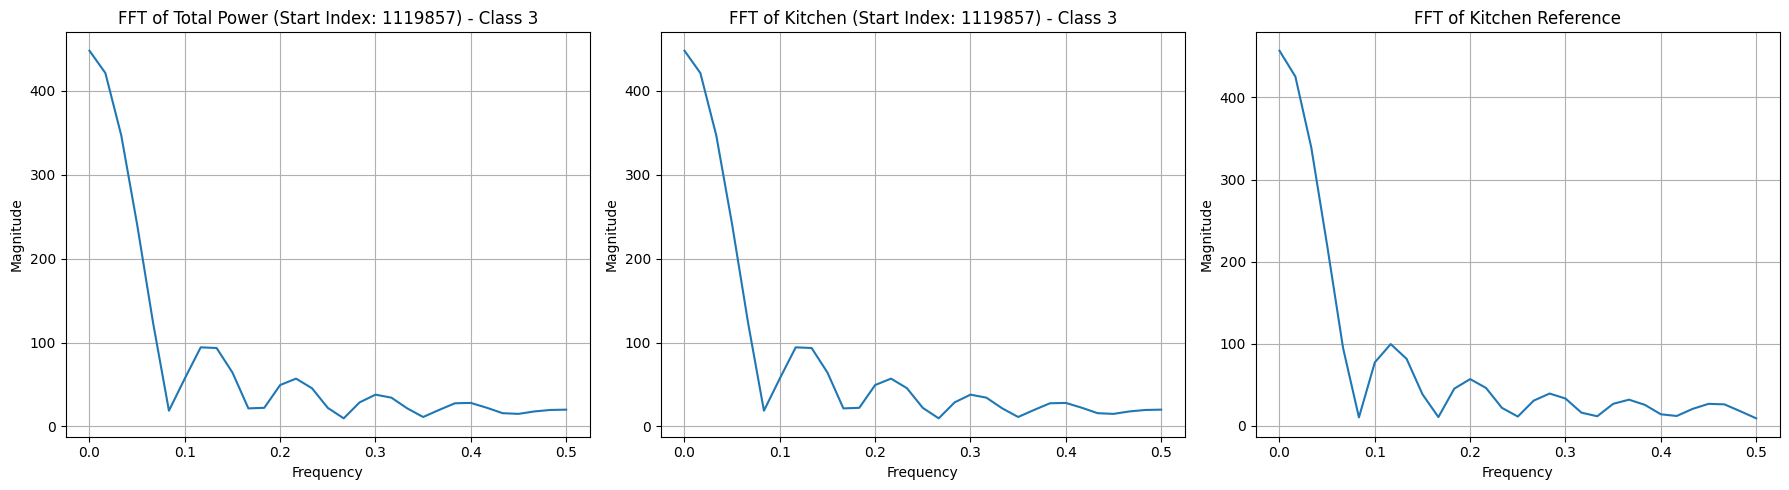

In [68]:
import random
def classify_windows(ref_fft, total_power_fft_window, kitchen_fft_window, min_total_power_dist, min_kitchen_dist, mean):
    # Calculate amplitudes
    ref_amp = np.abs(ref_fft)
    total_power_amp = np.abs(total_power_fft_window)
    kitchen_amp = np.abs(kitchen_fft_window)

    # Calculate Euclidean distances
    dist_total_power = distance.euclidean(ref_amp, total_power_amp)
    dist_kitchen = distance.euclidean(ref_amp, kitchen_amp)

    # Perform classification
    if dist_total_power < min_total_power_dist and dist_kitchen < min_kitchen_dist:
        if np.mean(total_power_amp >= ref_amp) >= mean:
            return 3
        else:
            return 4
    elif dist_total_power < min_total_power_dist:
        return 1
    elif dist_kitchen < min_kitchen_dist:
        return 2
    else:
        if np.mean(total_power_amp >= ref_amp) >= mean:
            return 0
        else:
            return 4

def random_start_index_with_condition(length, window_size, min_start):
    start = random.randint(min_start, length - window_size)
    return start

def classify_and_plot_windows_3(ref_fft, ref_index, min_total_power_dist, min_kitchen_dist, mean, iterations=5, recursion_limit=5):
    # Define window size
    window_size = 60
    found = False

    for _ in range(iterations):
        # Randomly select a start index
        start_index = random_start_index_with_condition(len(df_reset), window_size, 1000)
        end_index = start_index + window_size

        # Compute the associated frequencies for the window size
        freq_window = np.fft.rfftfreq(window_size, d=1)

        # Compute FFTs for the randomly selected windows
        total_power_fft_window = np.fft.rfft(df_reset['total_power'][start_index:end_index])
        kitchen_fft_window = np.fft.rfft(df_reset['Kitchen'][start_index:end_index])

        # Perform window classification
        class_label = classify_windows(ref_fft, total_power_fft_window, kitchen_fft_window, min_total_power_dist, min_kitchen_dist, mean)

        # If class is 0 or 3, then plot the FFTs, print the classification and set found to True
        if class_label in [3]:
            found = True
            print(f'Classification for window starting at index {start_index}: {class_label}')

            # Plot FFTs for the randomly selected window with classifications
            fig, axs = plt.subplots(1, 3, figsize=(18, 5))

            axs[0].plot(freq_window, np.abs(total_power_fft_window))
            axs[0].set_title(f'FFT of Total Power (Start Index: {start_index}) - Class {class_label}')
            axs[0].set_xlabel('Frequency')
            axs[0].set_ylabel('Magnitude')
            axs[0].grid(True)

            axs[1].plot(freq_window, np.abs(kitchen_fft_window))
            axs[1].set_title(f'FFT of Kitchen (Start Index: {start_index}) - Class {class_label}')
            axs[1].set_xlabel('Frequency')
            axs[1].set_ylabel('Magnitude')
            axs[1].grid(True)

            # Plot FFT of the reference kitchen window for comparison
            axs[2].plot(freq_window, np.abs(ref_fft))
            axs[2].set_title('FFT of Kitchen Reference')
            axs[2].set_xlabel('Frequency')
            axs[2].set_ylabel('Magnitude')
            axs[2].grid(True)

            # Adjust layout for better spacing
            plt.tight_layout()
            plt.show()

    # If no 0 or 3 classification is found, call the function again
    if not found and recursion_limit > 0:
        classify_and_plot_windows_3(ref_fft, ref_index, min_total_power_dist, min_kitchen_dist, mean, iterations, recursion_limit-1)

# Compute the FFT of the reference window
ref_fft = np.fft.rfft(df_reset['Kitchen'][ref_index : ref_index + window_size].values)

# Run the classification and plotting function
ref_index = 1021
window_size = 60
min_total_power_dist = 100 #amplitude of frequency
min_kitchen_dist = 100
mean = 0.4
classify_and_plot_windows_3(ref_fft, ref_index, min_total_power_dist, min_kitchen_dist, mean, recursion_limit=250)


The next code is stating that our reference is not in both kitchen and total_power, hence isnt in use. 

Classification for window starting at index 204625: 0


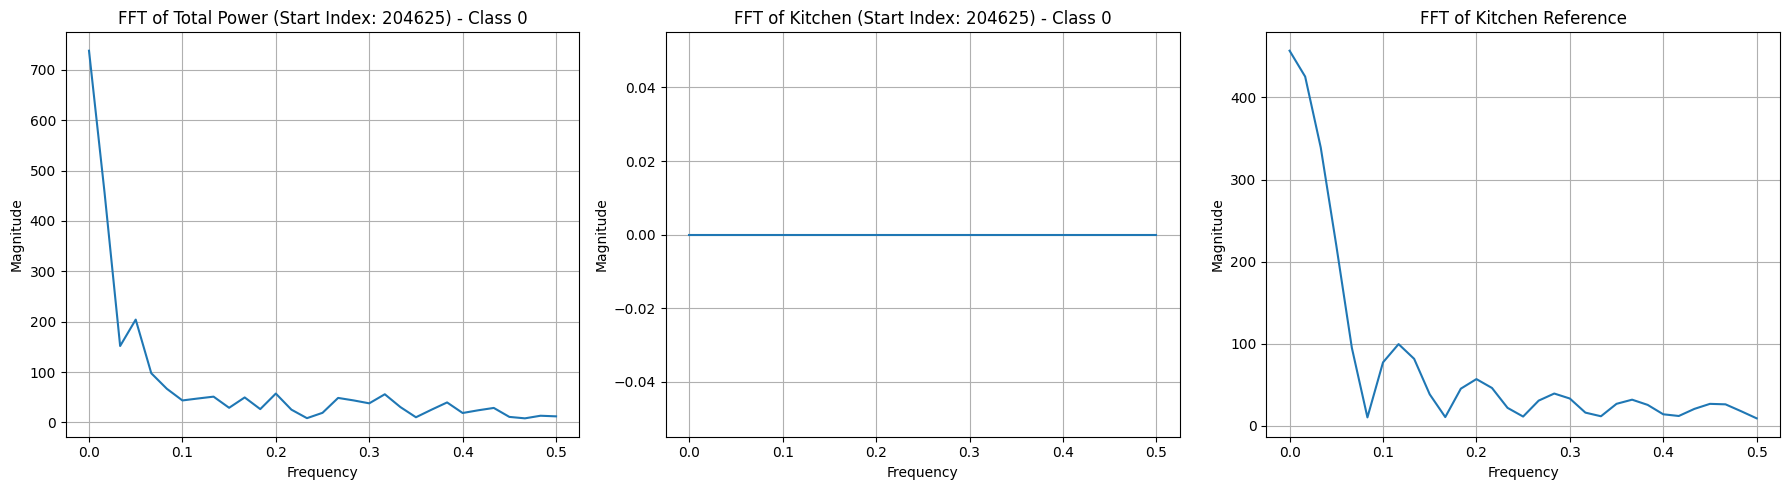

In [67]:

def classify_and_plot_windows_0(ref_fft, ref_index, min_total_power_dist, min_kitchen_dist, mean, iterations=5, recursion_limit=5):
    # Define window size
    window_size = 60
    found = False

    for _ in range(iterations):
        # Randomly select a start index
        start_index = random_start_index_with_condition(len(df_reset), window_size, 1000)
        end_index = start_index + window_size

        # Compute the associated frequencies for the window size
        freq_window = np.fft.rfftfreq(window_size, d=1)

        # Compute FFTs for the randomly selected windows
        total_power_fft_window = np.fft.rfft(df_reset['total_power'][start_index:end_index])
        kitchen_fft_window = np.fft.rfft(df_reset['Kitchen'][start_index:end_index])

        # Perform window classification
        class_label = classify_windows(ref_fft, total_power_fft_window, kitchen_fft_window, min_total_power_dist, min_kitchen_dist, mean)

        # If class is 0 or 3, then plot the FFTs, print the classification and set found to True
        if class_label in [0]:
            found = True
            print(f'Classification for window starting at index {start_index}: {class_label}')

            # Plot FFTs for the randomly selected window with classifications
            fig, axs = plt.subplots(1, 3, figsize=(18, 5))

            axs[0].plot(freq_window, np.abs(total_power_fft_window))
            axs[0].set_title(f'FFT of Total Power (Start Index: {start_index}) - Class {class_label}')
            axs[0].set_xlabel('Frequency')
            axs[0].set_ylabel('Magnitude')
            axs[0].grid(True)

            axs[1].plot(freq_window, np.abs(kitchen_fft_window))
            axs[1].set_title(f'FFT of Kitchen (Start Index: {start_index}) - Class {class_label}')
            axs[1].set_xlabel('Frequency')
            axs[1].set_ylabel('Magnitude')
            axs[1].grid(True)

            # Plot FFT of the reference kitchen window for comparison
            axs[2].plot(freq_window, np.abs(ref_fft))
            axs[2].set_title('FFT of Kitchen Reference')
            axs[2].set_xlabel('Frequency')
            axs[2].set_ylabel('Magnitude')
            axs[2].grid(True)

            # Adjust layout for better spacing
            plt.tight_layout()
            plt.show()

    # If no 0 or 3 classification is found, call the function again
    if not found and recursion_limit > 0:
        classify_and_plot_windows_0(ref_fft, ref_index, min_total_power_dist, min_kitchen_dist, mean, iterations, recursion_limit-1)

# Compute the FFT of the reference window
ref_fft = np.fft.rfft(df_reset['Kitchen'][ref_index : ref_index + window_size].values)

# Run the classification and plotting function
ref_index = 1021
window_size = 60
min_total_power_dist = 100 #amplitude of frequency
min_kitchen_dist = 100
mean = 0.4
classify_and_plot_windows_0(ref_fft, ref_index, min_total_power_dist, min_kitchen_dist, mean, recursion_limit=250)

The next is corresponding to our reference being shown in total power but not in the kitchen. Hence we can say that the reference appliance is not being used in the kitchen. It or something similar to it is being used in other rooms, and hence is reflecting in our total power. 

Classification for window starting at index 1203880: 1


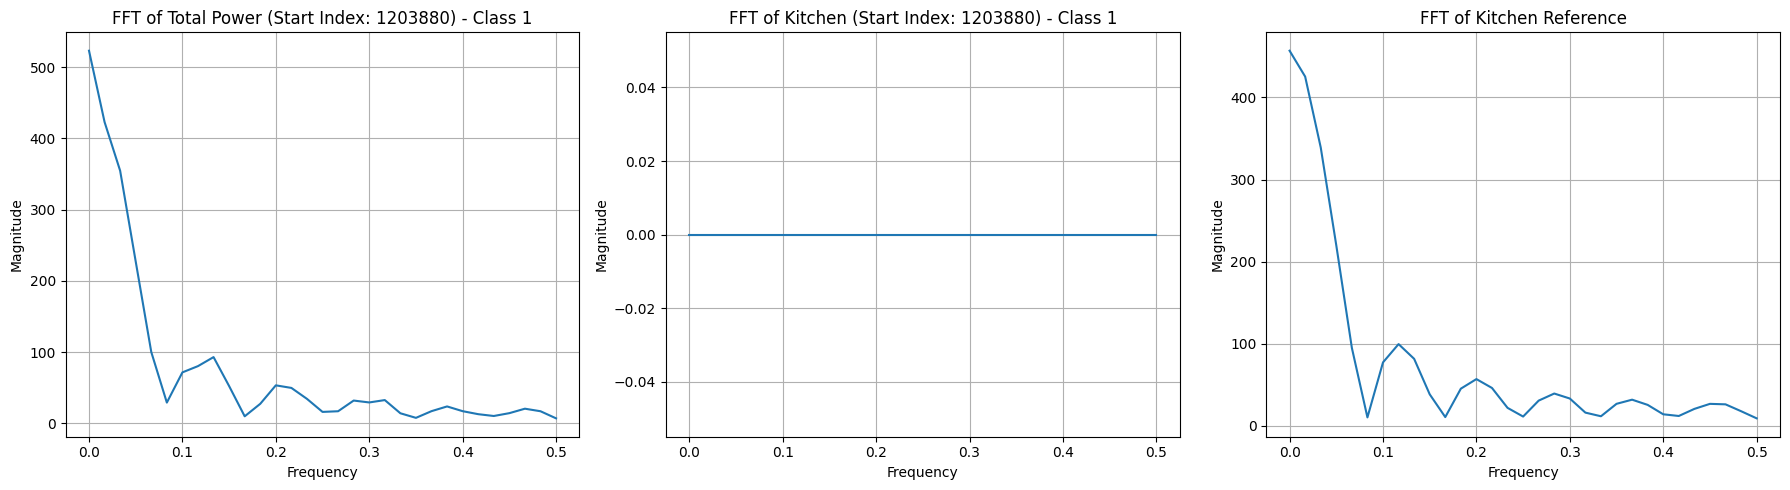

In [70]:

def classify_and_plot_windows_1(ref_fft, ref_index, min_total_power_dist, min_kitchen_dist, mean, iterations=5, recursion_limit=5):
    # Define window size
    window_size = 60
    found = False

    for _ in range(iterations):
        # Randomly select a start index
        start_index = random_start_index_with_condition(len(df_reset), window_size, 1000)
        end_index = start_index + window_size

        # Compute the associated frequencies for the window size
        freq_window = np.fft.rfftfreq(window_size, d=1)

        # Compute FFTs for the randomly selected windows
        total_power_fft_window = np.fft.rfft(df_reset['total_power'][start_index:end_index])
        kitchen_fft_window = np.fft.rfft(df_reset['Kitchen'][start_index:end_index])

        # Perform window classification
        class_label = classify_windows(ref_fft, total_power_fft_window, kitchen_fft_window, min_total_power_dist, min_kitchen_dist, mean)

        # If class is 0 or 3, then plot the FFTs, print the classification and set found to True
        if class_label in [1]:
            found = True
            print(f'Classification for window starting at index {start_index}: {class_label}')

            # Plot FFTs for the randomly selected window with classifications
            fig, axs = plt.subplots(1, 3, figsize=(18, 5))

            axs[0].plot(freq_window, np.abs(total_power_fft_window))
            axs[0].set_title(f'FFT of Total Power (Start Index: {start_index}) - Class {class_label}')
            axs[0].set_xlabel('Frequency')
            axs[0].set_ylabel('Magnitude')
            axs[0].grid(True)

            axs[1].plot(freq_window, np.abs(kitchen_fft_window))
            axs[1].set_title(f'FFT of Kitchen (Start Index: {start_index}) - Class {class_label}')
            axs[1].set_xlabel('Frequency')
            axs[1].set_ylabel('Magnitude')
            axs[1].grid(True)

            # Plot FFT of the reference kitchen window for comparison
            axs[2].plot(freq_window, np.abs(ref_fft))
            axs[2].set_title('FFT of Kitchen Reference')
            axs[2].set_xlabel('Frequency')
            axs[2].set_ylabel('Magnitude')
            axs[2].grid(True)

            # Adjust layout for better spacing
            plt.tight_layout()
            plt.show()

    # If no 0 or 3 classification is found, call the function again
    if not found and recursion_limit > 0:
        classify_and_plot_windows_1(ref_fft, ref_index, min_total_power_dist, min_kitchen_dist, mean, iterations, recursion_limit-1)
        
ref_fft = np.fft.rfft(df_reset['Kitchen'][ref_index : ref_index + window_size].values)
ref_index = 1021
window_size = 60
min_total_power_dist = 100 #amplitude of frequency
min_kitchen_dist = 100
mean = 0.4
classify_and_plot_windows_1(ref_fft, ref_index, min_total_power_dist, min_kitchen_dist, mean, recursion_limit=250)

The next observation tells us that the reference is being used in the kitchen, but it isnt reflection in total power. This is an ERROR observation. 

Classification for window starting at index 998134: 2


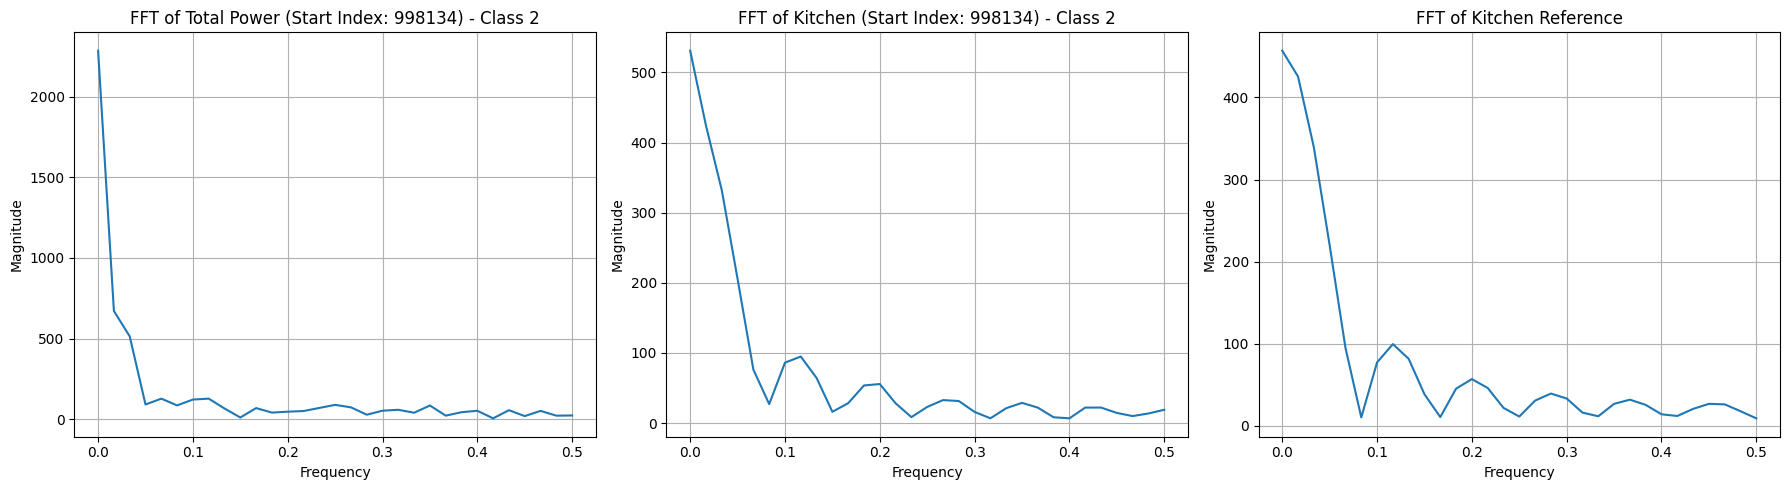

In [71]:

def classify_and_plot_windows_2(ref_fft, ref_index, min_total_power_dist, min_kitchen_dist, mean, iterations=5, recursion_limit=5):
    # Define window size
    window_size = 60
    found = False

    for _ in range(iterations):
        # Randomly select a start index
        start_index = random_start_index_with_condition(len(df_reset), window_size, 1000)
        end_index = start_index + window_size

        # Compute the associated frequencies for the window size
        freq_window = np.fft.rfftfreq(window_size, d=1)

        # Compute FFTs for the randomly selected windows
        total_power_fft_window = np.fft.rfft(df_reset['total_power'][start_index:end_index])
        kitchen_fft_window = np.fft.rfft(df_reset['Kitchen'][start_index:end_index])

        # Perform window classification
        class_label = classify_windows(ref_fft, total_power_fft_window, kitchen_fft_window, min_total_power_dist, min_kitchen_dist, mean)

        # If class is 0 or 3, then plot the FFTs, print the classification and set found to True
        if class_label in [2]:
            found = True
            print(f'Classification for window starting at index {start_index}: {class_label}')

            # Plot FFTs for the randomly selected window with classifications
            fig, axs = plt.subplots(1, 3, figsize=(18, 5))

            axs[0].plot(freq_window, np.abs(total_power_fft_window))
            axs[0].set_title(f'FFT of Total Power (Start Index: {start_index}) - Class {class_label}')
            axs[0].set_xlabel('Frequency')
            axs[0].set_ylabel('Magnitude')
            axs[0].grid(True)

            axs[1].plot(freq_window, np.abs(kitchen_fft_window))
            axs[1].set_title(f'FFT of Kitchen (Start Index: {start_index}) - Class {class_label}')
            axs[1].set_xlabel('Frequency')
            axs[1].set_ylabel('Magnitude')
            axs[1].grid(True)

            # Plot FFT of the reference kitchen window for comparison
            axs[2].plot(freq_window, np.abs(ref_fft))
            axs[2].set_title('FFT of Kitchen Reference')
            axs[2].set_xlabel('Frequency')
            axs[2].set_ylabel('Magnitude')
            axs[2].grid(True)

            # Adjust layout for better spacing
            plt.tight_layout()
            plt.show()

    # If no 0 or 3 classification is found, call the function again
    if not found and recursion_limit > 0:
        classify_and_plot_windows_2(ref_fft, ref_index, min_total_power_dist, min_kitchen_dist, mean, iterations, recursion_limit-1)


ref_fft = np.fft.rfft(df_reset['Kitchen'][ref_index : ref_index + window_size].values)

ref_index = 1021
window_size = 60
min_total_power_dist = 100 #amplitude of frequency
min_kitchen_dist = 100
mean = 0.4
classify_and_plot_windows_2(ref_fft, ref_index, min_total_power_dist, min_kitchen_dist, mean, recursion_limit=250)

In conclusion, our algorithm here is called accurate if it correctly identifies if our appliance called "reference" is being used in the kitchen AND is reflected in total_power when its being used. 
So it is accurate if:
1) It is not being used, and hence doesnt show up in kitchen or total_power.
2) It is being used and shows up in both kitchen and power. 

Our algorithm additionally tells us if an appliance is being used, which is similar to reference in other rooms/domains within the house. 
Further things we can do is handle collission error (index 1 of counter matrix) by comparing more parameters. We can handle non collission errors (counter matrix index 2) by employing more rigourous algorithms that accurately change our threshold parameters, rather than heuristically (the method that has been employed right now),